# Kaggle titanic competition

## Introduction

In this project I am going to explore one of the most popular dataset - [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview). The goal is to predict which passengers survived the Titanic shipwreck by constructing a model to do this I am going to test and optimize different models to achieve the best possible score.

### Summary of results

After trying different algorithms such as: Random Forest, K-NN, Logistic Regression, MLP Classifier, SVC I got accuracy of 0.78947 submitting predicted values to Kaggle. By transforming data I used following columns to make a prediction: 'Title_Mr', 'Title_Officer', 'Pclass_1', 'family_4+ family'.

## Data exploration

In [398]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

%matplotlib inline

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [357]:
train.shape

(891, 12)

In [358]:
holdout.shape

(418, 11)

In [359]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [360]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Train dataset contains 891 rows representing passengers with 12 columns representing different information about them, including *Survived* describing if a particular person survided-1 or not-0. Test dataset contains similar information except *Survived* column is missing. 

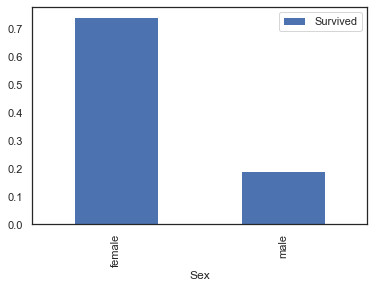

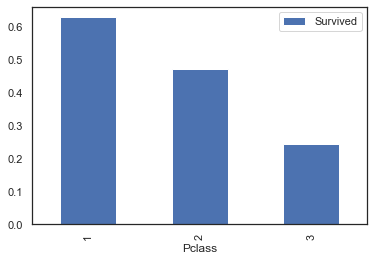

In [361]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
ticket_pivot = train.pivot_table(index='Pclass', values='Survived')
ticket_pivot.plot.bar()
plt.show()

We can see some relationships between gender and ticket class.

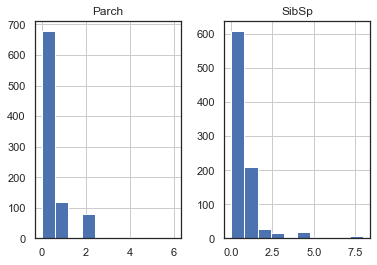

In [362]:
train[['SibSp','Parch']].hist(bins=10)
plt.show()

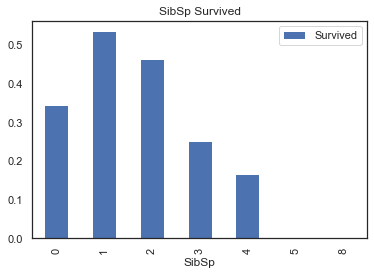

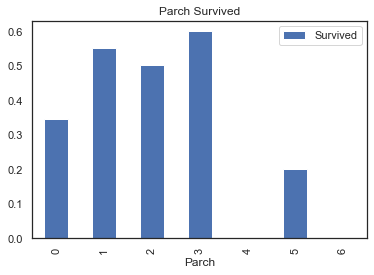

In [363]:
train.pivot_table(index='SibSp',values='Survived').plot.bar(title='SibSp Survived')
train.pivot_table(index='Parch',values='Survived').plot.bar(title='Parch Survived')

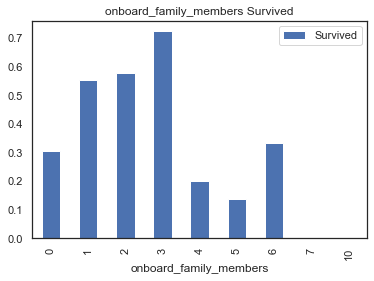

In [364]:
train['onboard_family_members'] = train['SibSp'] + train['Parch']
train.pivot_table(index='onboard_family_members',values='Survived').plot.bar(title='onboard_family_members Survived')

It looks like if people were alone on board they mostly died. If they had 1-3 family members with them they mostly survived and if they had more then 3 family members they didn't survived. Because of that we can apply binning and create a new categorical column sumarizing our onboard_family_members as following:
- 0 family, if the passanger had zero family members onboard
- 1-3 family, if the passanger had 1-3 family members obnboard
- 4+ family, if passanger had more then 4 family members obnboard

## Data cleaning

In [365]:
def process_family(df):
    df['onboard_family_members'] = df['SibSp'] + df['Parch']
    cut_points = [-1,0,3,11]
    label_names = ["0 family","1-3 family","4+ family"]
    df["family"] = pd.cut(df["onboard_family_members"],cut_points,labels=label_names)
    return df

In [366]:
# loading earlier prepared functions to the notebook
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop([column_name],axis=1)
    return df

In [419]:
def transform_titanic(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_cabin(df)
    df = process_titles(df)
    df = process_family(df)
    for col in ["Age_categories", "Fare_categories","Title", "Cabin_type","Sex","Pclass","family"]:
        df = create_dummies(df,col)
    df_new = df.drop(["Ticket","Age","Fare","Name","Embarked"],axis=1).copy()
    return df_new


train_clean = transform_titanic(train).copy()
test_clean = transform_titanic(holdout).copy()

In [368]:
# sanity check
train_clean.head(3)

,Survived,SibSp,Parch,onboard_family_members,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,...,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,family_0 family,family_1-3 family,family_4+ family
0,0,1,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0
1,1,1,0,1,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,1,1,0,0


Now our data contains only numerical values. To avoid overfitting lets drop columns which are mutually correlated.
### Collinearity

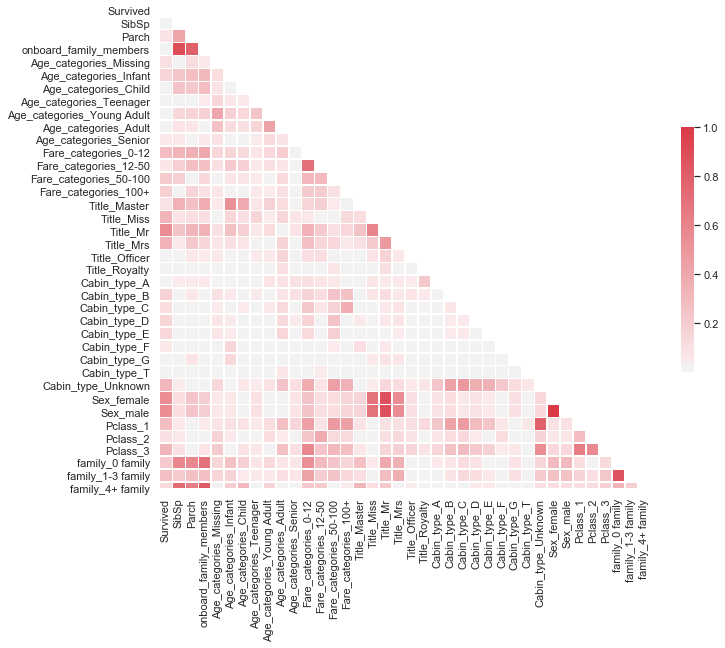

In [369]:
def plot_correlation_heatmap(df):
    corr = abs(df.corr())
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
plot_correlation_heatmap(train_clean)

As we can see *Sex_male and Sex_female* are correlated to our newly created titles once titles provide more information lets drop them. Lets also drop *SibSp amd Parch* once we transformed that data too.

In [420]:
def drop_similar(df):
    df = df.drop(['onboard_family_members','Sex_female','Sex_male','SibSp','Parch','Age_categories_Missing','Cabin_type_Unknown','PassengerId'],axis=1)
    return df

train_clean = drop_similar(train_clean)

## Feature selection

Lets write a function which can help us with feature selection using RFECV algorithm. We will use Random forest and Logistic regression to determine best features.

In [371]:
def select_features(df,n=0):
    df = df.dropna(axis=1)
    df = df.select_dtypes(exclude=['object'])
    all_X = df.drop(['Survived'],axis=1)
    all_y = df['Survived']
    model = [
        RandomForestClassifier(random_state=1),
        LogisticRegression()
            ]
    selector = RFECV(model[n],cv=10)
    selector.fit(all_X, all_y)
    best_features = all_X.columns[selector.support_]
    print(best_features)
    return best_features

In [372]:
print('Features selected by Random forest')
train_features_rf = select_features(train_clean)
print('Features selected by Logistic regression')
train_features_lr = select_features(train_clean,1)

Index(['Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'family_0 family', 'family_1-3 family', 'family_4+ family'],
      dtype='object')
Index(['Title_Mr', 'Title_Officer', 'Pclass_1', 'family_4+ family'], dtype='object')


As we can see Random forest returned much more features then Logistic regression selector. Lets try both.
## Model selection
We can use Grid search to find the best hyperparameters for our models and to select the best algorithm.

In [422]:
def select_model(df,features):
    all_X = df[features]
    all_y = df['Survived']
    models = [
        {
            'name':'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters':
            {
                'n_neighbors': range(3,20,2),
                'weights': ['distance','uniform'],
                'algorithm': ['ball_tree','kd_tree','brute'],
                'p': [1,2]
            }
        },
        {
            'name':'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters':
            {
                'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'class_weight': [None,'balanced']
            }
        },
        {
            'name':'RandomForestClassifier',
            'estimator': RandomForestClassifier(random_state=1),
            'hyperparameters':
            {
                'n_estimators': [10,20,30,50],
                'criterion': ['entropy','gini'],
                'max_depth': [2,5,10],
                'max_features': ['log2','sqrt'],
                'min_samples_leaf': [1,2,3,5,8],
                'class_weight': [None,'balanced']
            }
        },
        {
            'name':'MLPClassifier',
            'estimator': MLPClassifier(),
            'hyperparameters':
            {
                'hidden_layer_sizes':[(5,),(5,5),(5,5,5)],
                'activation': ['logistic','relu'],
                'max_iter':[200,1000]
            }
        },
        {
            'name':'SVC',
            'estimator': SVC(),
            'hyperparameters':
            {
                'kernel':['linear', 'rbf'],
                'gamma' : ['scale','auto'],
                'probability': [False,True]
            }
        }

            ]
    best_model =[]
    for model in models:
        model_perf={}
        grid = GridSearchCV(model['estimator'],model['hyperparameters'],cv=10)
        grid.fit(all_X, all_y)
        model_perf['score'] = grid.best_score_
#         model_perf['variance'] = grid.cv_results_['std_test_score']
        model_perf['params'] = grid.best_params_
        model_perf['estimator'] = grid.best_estimator_
        best_model.append(model_perf)
    return best_model
    

In [ ]:
def lost_function(y_true, y_pred):
    
    
scorer = make_scorer(my_custom_loss_func, greater_is_better=True)

In [423]:
models_performance = select_model(train_clean,train_features_rf)
models_performance_simplified = select_model(train_clean,train_features_lr)

C:\Apps\ProgramFiles\Continuum\Anaconda2\envs\pablo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\ProgramFiles\Continuum\Anaconda2\envs\pablo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\ProgramFiles\Continuum\Anaconda2\envs\pablo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\ProgramFiles\Continuum\Anaconda2\envs\pablo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Op

C:\Apps\ProgramFiles\Continuum\Anaconda2\envs\pablo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\ProgramFiles\Continuum\Anaconda2\envs\pablo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\ProgramFiles\Continuum\Anaconda2\envs\pablo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Apps\ProgramFiles\Continuum\Anaconda2\envs\pablo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Op

In [425]:
models_performance_simplified

[{'score': 0.8294132334581773,
  'params': {'algorithm': 'brute',
   'n_neighbors': 3,
   'p': 1,
   'weights': 'distance'},
  'estimator': KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                       weights='distance')},
 {'score': 0.8282896379525593,
  'params': {'class_weight': None, 'solver': 'newton-cg'},
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                     warm_start=False)},
 {'score': 0.8305368289637952,
  'params': {'class_weight': 'balanced',
   'criterion': 'entropy',
   'max_depth': 5,
   'max_features': 'log2',
   'min_samples_leaf': 3,
   'n_estimators': 20},
  'estimator': RandomFore

In [426]:
models_performance

[{'score': 0.837278401997503,
  'params': {'algorithm': 'kd_tree',
   'n_neighbors': 5,
   'p': 1,
   'weights': 'uniform'},
  'estimator': KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                       weights='uniform')},
 {'score': 0.823820224719101,
  'params': {'class_weight': None, 'solver': 'newton-cg'},
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                     warm_start=False)},
 {'score': 0.8406741573033708,
  'params': {'class_weight': 'balanced',
   'criterion': 'gini',
   'max_depth': 10,
   'max_features': 'sqrt',
   'min_samples_leaf': 1,
   'n_estimators': 30},
  'estimator': RandomForest

## Model sumbission

In [432]:
def save_submission_file(estimator,features,filename='submission.csv'):
    test_X = test_clean[features]
    predictions = estimator.predict(test_X)
    submission = pd.concat([test_clean['PassengerId'],pd.Series(predictions)],axis=1)
    submission.columns = ['PassengerId','Survived']
    submission.to_csv(filename,index=False)

In [447]:
save_submission_file(models_performance[4]['estimator'],train_features_rf,'submission8.csv')

In [436]:
pd.read_csv('submission.csv')

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Conclusion

After trying different algorithms such as: Random Forest, K-NN, Logistic Regression, MLP Classifier, SVC we got accuracy score 0.78947 submitting predicted values to Kaggle. That was using following columns to make a prediction: 'Title_Mr', 'Title_Officer', 'Pclass_1', 'family_4+ family'. So it were columns returened by the Logistic selector.

When trying the same models with more features we got between 0.74162 and 0.77990 which means that using to much features our model became overfitting.